Parameters

In [9]:
MODEL_CHECKPOINT = "bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16"

Data Pre-Processing and Preparing

Setting up XLNet

In [10]:
from transformers import AutoModel

AutoModel.from_pretrained(MODEL_CHECKPOINT)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [11]:
import torch
from transformers import AutoModel


class BlueBERTClassifier(torch.nn.Module):

    def __init__(self, checkpoint, dropout=0.5):

        super(BlueBERTClassifier, self).__init__()
        
        self.checkpoint = checkpoint
        self.bluebert = AutoModel.from_pretrained(checkpoint, num_labels=2)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear2 = torch.nn.Linear(self.bluebert.config.hidden_size, 2)


    def forward(self, input_ids, attention_mask, token_type_ids):

        bluebert_output = self.bluebert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
        dropout_output = self.dropout(bluebert_output.pooler_output)
        output = self.linear2(dropout_output)
        
        return output

In [12]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

In [1]:
import os
from data_preparing import get_dataloader, split_data
from data_preprocessing import xml_to_df
from global_parameters import MAX_LEN, TEST_BATCH_SIZE, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE


xml_files = []
data_path = "../data-querying/results/"
folder_names = ["human_medical_data/", "veterinary_medical_data/"]
for folder in folder_names:
    xml_files.append(os.listdir(data_path + folder))
max_size = 50

hum_df, vet_df = xml_to_df(data_path, folder_names, xml_files)
train_set, val_set, test_set = split_data(hum_df, vet_df, max_size)

train_set["title_abstract"] = train_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
val_set["title_abstract"] = val_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
test_set["title_abstract"] = test_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

train_dataloader = get_dataloader(train_set.title_abstract, train_set.labels, tokenizer, TRAIN_BATCH_SIZE, MAX_LEN)
val_dataloader = get_dataloader(val_set.title_abstract, val_set.labels, tokenizer, VAL_BATCH_SIZE, MAX_LEN)
test_dataloader = get_dataloader(test_set.title_abstract, test_set.labels, tokenizer, TEST_BATCH_SIZE, MAX_LEN)

  1%|▏         | 1290/98998 [00:00<00:14, 6526.59it/s]

Processing medical field: human_medicine


 36%|███▌      | 35194/98998 [00:03<00:04, 15159.48it/s]

Processing medical field: veterinary_medicine


100%|██████████| 98998/98998 [00:14<00:00, 6798.19it/s] 


NameError: name 'tokenizer' is not defined

In [15]:
train_set.head()

,pmid,text_types,title,abstract,meshtermlist,labels,title_abstract
0,7984192,[Journal Article],transluminal placement of endovascular stent-g...,the usual treatment for thoracic aortic aneury...,"[Adult, Aged, Aortic Dissection, Angioplasty, ...","[1, 0]",transluminal placement of endovascular stent-g...
1,31635203,[Journal Article],revisiting a previously validated temperament ...,this study assessed the feasibility and reprod...,[],"[0, 1]",revisiting a previously validated temperament ...
2,36496846,[Journal Article],first identification and phylogenetic analysis...,a novel circovirus called porcine circovirus t...,[],"[0, 1]",first identification and phylogenetic analysis...
3,28605608,"[Journal Article, Multicenter Study, Randomize...",canagliflozin and cardiovascular and renal eve...,background canagliflozin is a sodium-glucose c...,"[Aged, Albuminuria, Amputation, Surgical, Cana...","[1, 0]",canagliflozin and cardiovascular and renal eve...
4,24521131,"[Case Reports, Letter, Research Support, N.I.H...",how a single patient influenced hiv research--...,a follow-up report on a patient whose hiv infe...,"[Anti-Retroviral Agents, CD4 Lymphocyte Count,...","[1, 0]",how a single patient influenced hiv research--...


In [16]:
import os
from transformers import get_linear_schedule_with_warmup

from global_parameters import EPOCHS, LEARNING_RATE, PATH_SAVED_MODELS
from loss_fn import loss_fn
from training import train_model


train = True

model_filename = f"{MODEL_CHECKPOINT}.bin"
filenames = None if not os.path.exists(PATH_SAVED_MODELS) else os.listdir(PATH_SAVED_MODELS)

if filenames and model_filename in filenames and not train:
    model = BlueBERTClassifier(MODEL_CHECKPOINT)
    model.load_state_dict(torch.load(work_dir + model_filename))
    model.to(device)
    print(f"{model_filename} loaded.")
else:
    print("No saved model found or forced to train.")
    
    torch.cuda.empty_cache()
    
    model = BlueBERTClassifier(MODEL_CHECKPOINT)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )
    
    history = train_model(model, train_dataloader, val_dataloader, TRAIN_BATCH_SIZE, loss_fn, optimizer, device, scheduler, EPOCHS)

No saved model found or forced to train.


OutOfMemoryError: CUDA out of memory. Tried to allocate 120.00 MiB. GPU 0 has a total capacty of 2.00 GiB of which 0 bytes is free. Of the allocated memory 5.21 GiB is allocated by PyTorch, and 192.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

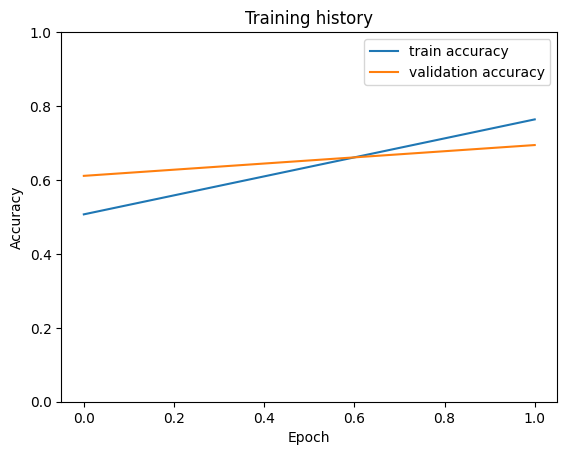

In [ ]:
from training import plot_performance_history


if 'history' in locals() and history:
    plot_performance_history(pd.DataFrame(history))

In [ ]:
from sklearn.metrics import classification_report

from global_parameters import LABELS_MAP
from predict import predict


test_preds = predict(model, test_set.title_abstract, tokenizer, device)
test_labels = [labels.index(max(labels)) for labels in test_set.labels]
preds_labels = [torch.argmax(pred).item() for pred in test_preds]
report = classification_report(test_labels, preds_labels, target_names=LABELS_MAP.keys())
print(report)

100%|██████████| 20/20 [00:01<00:00, 15.80it/s]


                     precision    recall  f1-score   support

     human_medicine       0.86      0.60      0.71        10
veterinary_medicine       0.69      0.90      0.78        10

           accuracy                           0.75        20
          macro avg       0.77      0.75      0.74        20
       weighted avg       0.77      0.75      0.74        20



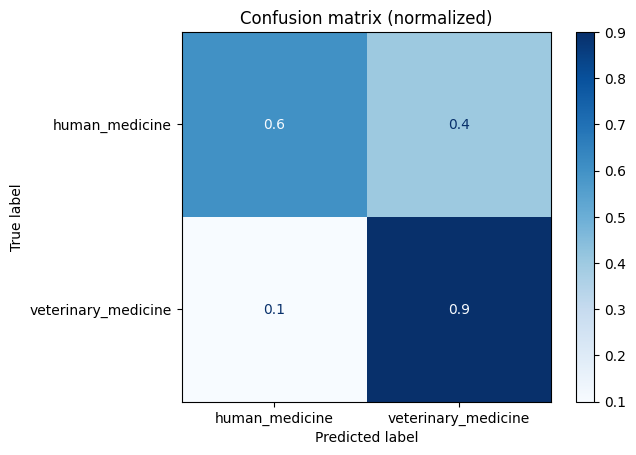

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from global_parameters import LABELS_MAP


labels = list(LABELS_MAP.keys())
test_classes = [labels[0] if label == 0 else labels[1] for label in test_labels]
preds_classes = [labels[0] if label == 0 else labels[1] for label in preds_labels]
disp = ConfusionMatrixDisplay.from_predictions(test_classes, preds_classes, labels=labels, normalize="true", cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix (normalized)")
plt.show()